# Entomics - Notebook
David Witt<br>
14th Jul 2019


# Contents
1. <a href='#sec01'>Overview</a>
2. <a href='#sec02'>Load libraries & data</a>
3. <a href='#sec03'>Data - summary stats</a>
4. <a href='#sec04'>EDA / Analysis</a>
5. <a href='#sec05'>Feature engineering</a>
6. <a href='#sec06'>Processing</a>
7. <a href='#sec07'>Modelling</a>
8. <a href='#sec08'>Improving data quality</a>
9. <a href='#sec09'>Black Soldier House Fly - Developmental cycle</a>

*Click on links above to jump to section*

<a id='sec01'></a>
# 1. Overview
Entomics creates agricultural products by feeding organic waste to insect larvae so that the waste is transformed into higher value biomass that can be more successfully utilised in the production of products, such as agricultural feeds.

The production process involves setting up trays with Black Soldier Fly larvae and feeding them organic source material on a daily basis. The amount of feed provided is a based on a set of criteria:
- Temperature
- Moisture / humidity
- Whether any food was leftover from previous feeding
- Whether any black larvae present - this would indicate they will be going into pupation and require harvesting soon
- Whether any dead larvae are present - this could be an indicator of disease
- Whether the tray is overpopulated

This inspection data would then be logged along with the feed amount provided (in litres)

## Our objective
What we want to achieve is predict how much food we need to give to the insects each day based on the inspection data. Ideally, this is a smooth feeding curve that you feed every day just the perfect amount for the insects to process it.

### Some key knowns:
These have been confirmed with Fotis.
1. Observations were done at a single site and in identical set-up over the time recorded. 4 people were involved in the data collection over time
2. Black Soldier Fly larvae used for all trays
3. <font color=red>Egg mass input (the amount of larvae) may vary from tray to tray</font>
4. <font color=red>Harvesting times and dates change from tray to tray</font>

### .. and some key unknowns:
1. Amount of larvae on the tray at any given time is unknown - it is also unclear whether the size of the trays are consistent
2. There is no metric that indicates whether a feeding contributes to a positive outcome
3. Yield for the tray

<a id='sec02'></a>
# 2. Load libararies & data

In [397]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# Load data
df = pd.read_csv('data/FeedRecords.csv')
df.head()

,Date,Tray,Age,Temperature,Moisture,Food Left,Black Larvae,Dead Larvae,Overpopulated,Previous Feed 3,Previous Feed 2,Previous Feed 1,Feed
0,06/10/2017,331,24,0,-3,None,True,False,False,0.0,3.0,3.0,3
1,06/10/2017,335,24,-1,-3,None,True,False,False,0.0,1.0,0.0,1
2,06/10/2017,338,24,-1,-3,None,True,False,False,0.0,1.0,0.0,1
3,06/10/2017,357,21,-1,-3,None,True,False,False,0.0,1.0,0.0,0
4,06/10/2017,358,21,-1,-3,None,True,False,False,0.0,1.0,0.0,0


<a id='sec03'></a>
# 3. Data - summary stats
First, we will look at general info about data using general pandas functions

In [398]:
df.shape

(11491, 13)

In [399]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11491 entries, 0 to 11490
Data columns (total 13 columns):
Date               11491 non-null object
Tray               11491 non-null int64
Age                11491 non-null int64
Temperature        11491 non-null int64
Moisture           11491 non-null int64
Food Left          11491 non-null object
Black Larvae       11491 non-null bool
Dead Larvae        11491 non-null bool
Overpopulated      11491 non-null bool
Previous Feed 3    9909 non-null float64
Previous Feed 2    10439 non-null float64
Previous Feed 1    10969 non-null float64
Feed               11491 non-null int64
dtypes: bool(3), float64(3), int64(5), object(2)
memory usage: 931.5+ KB


In [400]:
df.describe()

,Tray,Age,Temperature,Moisture,Previous Feed 3,Previous Feed 2,Previous Feed 1,Feed
count,11491.000000,11491.000000,11491.000000,11491.000000,9909.000000,10439.000000,10969.000000,11491.000000
mean,683.928292,12.879384,0.276042,-0.742494,2.985569,2.937829,2.886772,2.810286
std,190.008022,8.367770,0.721930,1.233315,1.689125,1.718018,1.753276,1.794887
min,331.000000,0.000000,-5.000000,-4.000000,0.000000,0.000000,0.000000,0.000000
25%,528.000000,6.000000,0.000000,-2.000000,2.000000,2.000000,1.000000,1.000000
50%,639.000000,12.000000,0.000000,-1.000000,3.000000,3.000000,3.000000,3.000000
75%,877.000000,19.000000,1.000000,0.000000,4.000000,4.000000,4.000000,4.000000
max,1037.000000,40.000000,3.000000,6.000000,7.000000,7.000000,7.000000,7.000000


In [401]:
df.isnull().sum()

Date                  0
Tray                  0
Age                   0
Temperature           0
Moisture              0
Food Left             0
Black Larvae          0
Dead Larvae           0
Overpopulated         0
Previous Feed 3    1582
Previous Feed 2    1052
Previous Feed 1     522
Feed                  0
dtype: int64

### Findings
- Only Previous Feed columns have NULL values in them
- Non-boolean features are primarily categorical (Feed later confirmed to be in Litres)

<a id='sec04'></a>
# 4. EDA / Analysis
The target variable is "Feed", which is how much food is given. This amount is heavily influenced by the amount of larvae on the tray, a variable which was <font color=red>not</font> provided.<br><br>
Ahead of training the model, we can only assume that this feed was adequate with the only exception being in cases where:
1. The following day has Food Leftover
2. Dead Larvae are present - indicates a problem with the tray, although not necessarily due to feeding
3. Overpopulation - indicates a problem with tray, although still lack of clarity whether this is desirable (e.g. increased yield) or undesirable


### Understanding inspections
To kick off, let's look at the number of inspections that have taken place, by date and by tray. 

First date in data: 2017-10-06 00:00:00
Last date in data: 2018-05-31 00:00:00
Number of days in period: 238 days 00:00:00
Number of days with an inspection: 218
Average inspections per day: 52.711009174311926


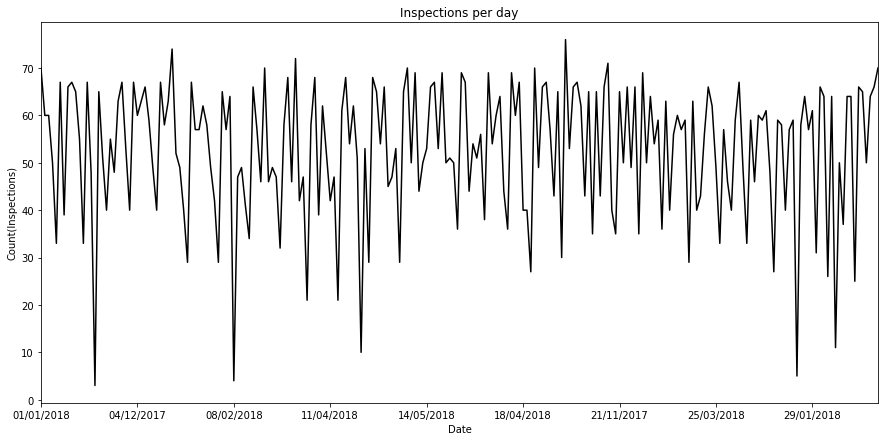

In [402]:
# Inspections per date
grouped = df['Feed'].groupby(df['Date']) 
fig, ax = plt.subplots(figsize=(15,7))
grouped.count().plot(ax=ax, color='black')
plt.title('Inspections per day')
plt.xlabel('Date')
plt.ylabel('Count(Inspections)')

from datetime import datetime  
from datetime import timedelta 
df['Date'] = pd.to_datetime(df['Date'],format='%d/%m/%Y',infer_datetime_format=False)
days_in_period = df.Date.max() - df.Date.min() + timedelta(days=1)
print('First date in data:', df.Date.min())
print('Last date in data:', df.Date.max())
print('Number of days in period:', days_in_period)
print('Number of days with an inspection:', len(df.Date.unique()))
print('Average inspections per day:', df.shape[0] / len(df.Date.unique()))

- Over the period where data is recorded, 91.6% of days had some inspections take place
- 53 inspections per day took place, on average. If we assume that every tray was inspected then there are an average of 50 trays in production at any given time
- There are a couple of points in the data where inspections were much lower than average

#### New features (Inspections per tray)

In [403]:
# Inspections per tray
insp_per_tray = df['Date'].groupby(df['Tray']).count()
df = pd.merge(df, insp_per_tray, on='Tray')
df.rename(columns={'Date_x': 'Date', 'Date_y': 'insp_per_tray'}, inplace=True)

### Understanding trays


First tray ID: 331
Last date in data: 1037
Number of trays in total: 551
Average inspections per tray: 20.85480943738657


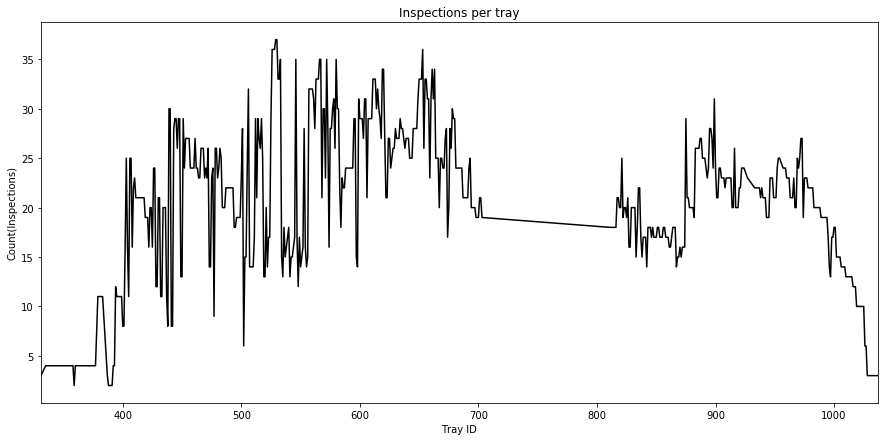

In [404]:
grouped = df['Feed'].groupby(df['Tray']) 
fig, ax = plt.subplots(figsize=(15,7))
grouped.count().plot(ax=ax, color='black')
plt.title('Inspections per tray')
plt.xlabel('Tray ID')
plt.ylabel('Count(Inspections)')

print('First tray ID:', df.Tray.min())
print('Last date in data:', df.Tray.max())
print('Number of trays in total:', len(df.Tray.unique()))
print('Average inspections per tray:', df.shape[0] / len(df.Tray.unique()))


- Tray ID's < 400 have fewer observations and, hence, may not be suitable for modelling (discard)
- There is a gap in numbering between 700 and 800 (703 & 810)
- There are fewer inspections per tray after ID 810 - this could be due to change in staff, change in production or different methodology

In [405]:
#df[df['Tray'] > 700]

### Understanding "Age"
The feature "Age" represents the age of the tray (in days) on the date an inspection was made. Therefore, we can assume that the Age at the date of last inspection represents the date that the tray was harvested.<br><br>  

Shortest tray age: 0
Longest tray age: 40
Average age of tray at harvest: 20.85480943738657


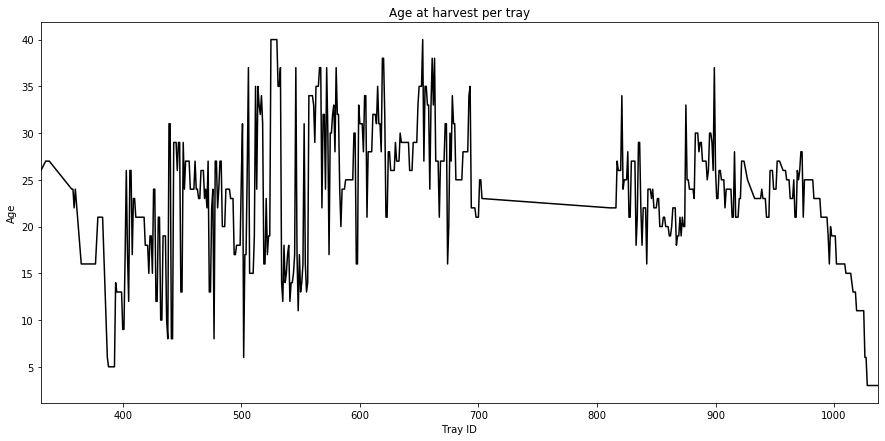

In [406]:
grouped = df['Age'].groupby(df['Tray']) 
fig, ax = plt.subplots(figsize=(15,7))
grouped.max().plot(ax=ax, color='black')
plt.title('Age at harvest per tray')
plt.xlabel('Tray ID')
plt.ylabel('Age')

print('Shortest tray age:', df.Age.min())
print('Longest tray age:', df.Age.max())
print('Average age of tray at harvest:', df.shape[0] / len(df.Tray.unique()))

- Average age of tray aligns with number of inspections per tray, as expected
- The total spread in age aligns with the developmental lifecycle of the Black Soldier Fly (see info following) - however, Fotis has indicated that we cannot assume that each tray starts with eggs on Day 0 and then hosts the same larvae until time of harvest - production process isn't that clean

Text(0, 0.5, 'Count(Trays)')

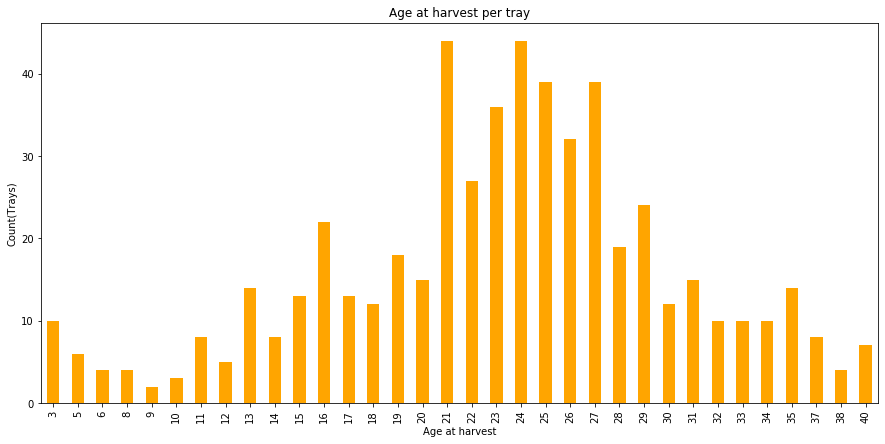

In [407]:
grouped = df['Age'].groupby(df['Tray'])
df2 = grouped.agg(['max','count'])
grouped2 = df2['count'].groupby(df2['max'])
fig, ax = plt.subplots(figsize=(15,7))
grouped2.count().plot.bar(ax=ax, color='orange')
plt.title('Age at harvest per tray')
plt.xlabel('Age at harvest')
plt.ylabel('Count(Trays)')

If we align this to the larval cycle, then the average tray lifespan correlates to the beginning of the pre-pupal stage (19 days) and the midpoint of the pupal stage (approx 33 days). This seems to be the key harvest zone.<br><br>
However, no data has been provided indicating why some trays have shorter cycles than others. For instance
- Larvae may be continuously added to some trays with larvae at varying stages within cycle
- Different output products may require larvae to be harvested at different stages
- There may be times where trays need to be discarded due to production or bio issues
<br>

#### New features (Inspection rate, Start age, age at harvest)
We can compare Age to inspections to determine which trays have missing inspections - these will be discarded later as will ones where inspections were not started at the beginning of its lifecycle. 

In [408]:
# Start age
start_age = df['Age'].groupby(df['Tray']).min()
df = pd.merge(df, start_age, on='Tray')
df.rename(columns={'Age_x': 'Age', 'Age_y': 'start_age'}, inplace=True)
# Age at harvest
age_at_harvest = df['Age'].groupby(df['Tray']).max()
df = pd.merge(df, age_at_harvest, on='Tray')
df.rename(columns={'Age_x': 'Age', 'Age_y': 'age_at_harvest'}, inplace=True)
# Inspection rate
df['inspection_rate'] = df['insp_per_tray'] / df['age_at_harvest']
df.head()

,Date,Tray,Age,Temperature,Moisture,Food Left,Black Larvae,Dead Larvae,Overpopulated,Previous Feed 3,Previous Feed 2,Previous Feed 1,Feed,insp_per_tray,start_age,age_at_harvest,inspection_rate
0,2017-10-06,331,24,0,-3,None,True,False,False,0.0,3.0,3.0,3,3,24,26,0.115385
1,2017-10-07,331,25,2,-2,None,True,False,False,3.0,3.0,3.0,3,3,24,26,0.115385
2,2017-10-08,331,26,0,-1,None,True,False,False,3.0,3.0,3.0,1,3,24,26,0.115385
3,2017-10-06,335,24,-1,-3,None,True,False,False,0.0,1.0,0.0,1,4,24,27,0.148148
4,2017-10-07,335,25,1,-3,None,True,False,False,1.0,0.0,1.0,0,4,24,27,0.148148


### Understanding feed
Feed is our target variable. The data shows that inspections are not recorded for every single day so our working assumption is that feedings do indeed happen daily even if the full inspection is logged less frequently.<br><br>
Per Fotis, the Feed value is measured in Litres (as opposed to being categorical)<br><br>
First, we will take a look at the distribution of values for Feed and the Previous columns.


Average daily feed: 2.8102863110260206


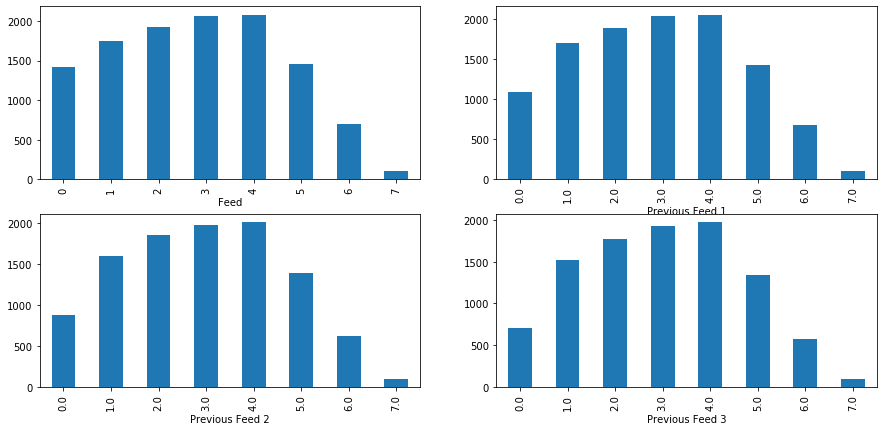

In [409]:
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3)
ax4 = fig.add_subplot(2, 2, 4)
grouped = df['Feed'].groupby(df['Feed']) 
grouped.count().plot.bar(ax=ax1)
print('Average daily feed:', df.Feed.mean())
grouped = df['Feed'].groupby(df['Previous Feed 1']) 
grouped.count().plot.bar(ax=ax2)
grouped = df['Feed'].groupby(df['Previous Feed 2']) 
grouped.count().plot.bar(ax=ax3)
grouped = df['Feed'].groupby(df['Previous Feed 3']) 
grouped.count().plot.bar(ax=ax4)

- Previous Feed 1/2/3 show similar distribution and are presumed to be the three previous days of feed
- For now, we will discard Previous Feed for simplicity, since this info should already be in the data

#### Reviewing feed per tray (average & total)

Text(0, 0.5, 'Average daily feed (Litres)')

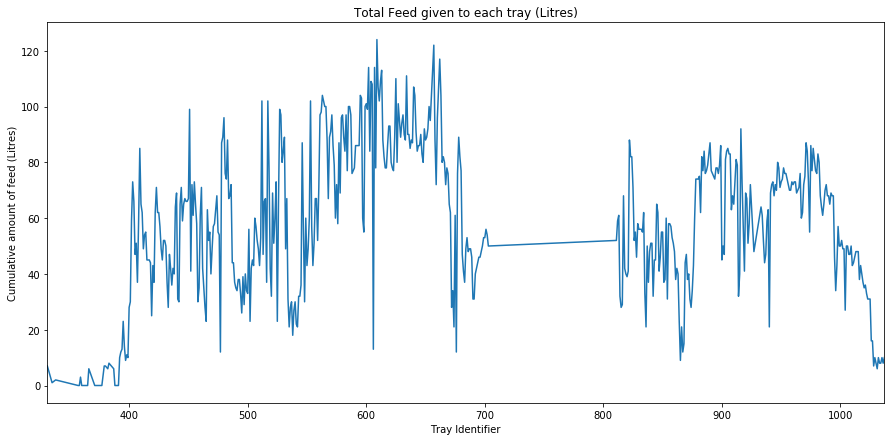

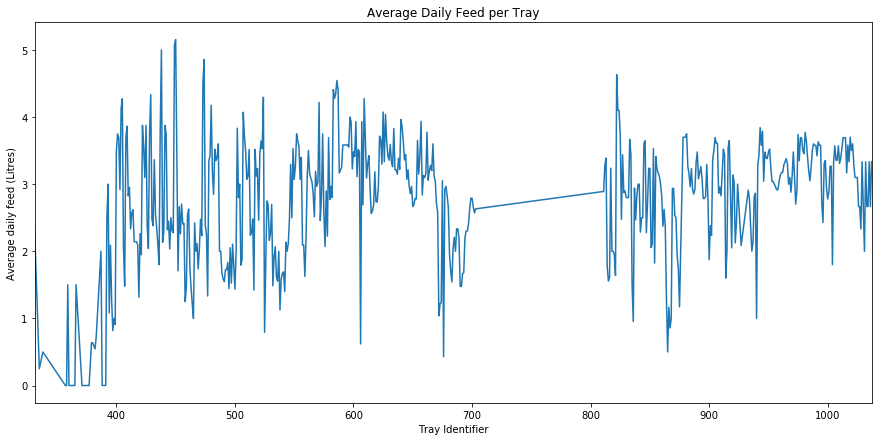

In [410]:
# Total feed
grouped = df['Feed'].groupby(df['Tray']) 
fig, ax = plt.subplots(figsize=(15,7))
grouped.sum().plot(ax=ax)
plt.title('Total Feed given to each tray (Litres)')
plt.xlabel('Tray Identifier')
plt.ylabel('Cumulative amount of feed (Litres)')
# Average daily feed
grouped = df['Feed'].groupby(df['Tray']) 
fig, ax = plt.subplots(figsize=(15,7))
grouped.mean().plot(ax=ax)
plt.title('Average Daily Feed per Tray')
plt.xlabel('Tray Identifier')
plt.ylabel('Average daily feed (Litres)')

There is a signficant amount of variance on total feed given per tray. This is a function of the age of the tray and the amount of larvae in the tray (size of tray). We do not know the amount of larvae so we can only assume that more feed equates to a larger tray.

The average daily feed per tray varies as well, but not as signifcantly as the total cumulative. Since we do not know the yield for each tray (or any other success measure for that matter) it is hard to understand whether higher averages equate to more successful outcomes.

#### New features - Feed per tray
Let's add 2 features to the data that will allow us to filter - one for total feed per tray and another for the average. Trays that anomalies may be removed later.

In [411]:
# Cumulative feed per tray
total_feed_per_tray = df['Feed'].groupby(df['Tray']).sum()
df = pd.merge(df, total_feed_per_tray, on='Tray')
df.rename(columns={'Feed_x': 'Feed', 'Feed_y': 'total_feed_per_tray'}, inplace=True)
# Average daily feed (based on inspection count)
df['average_daily_feed'] = df['total_feed_per_tray'] / df['insp_per_tray']
df.head()

,Date,Tray,Age,Temperature,Moisture,Food Left,Black Larvae,Dead Larvae,Overpopulated,Previous Feed 3,Previous Feed 2,Previous Feed 1,Feed,insp_per_tray,start_age,age_at_harvest,inspection_rate,total_feed_per_tray,average_daily_feed
0,2017-10-06,331,24,0,-3,None,True,False,False,0.0,3.0,3.0,3,3,24,26,0.115385,7,2.333333
1,2017-10-07,331,25,2,-2,None,True,False,False,3.0,3.0,3.0,3,3,24,26,0.115385,7,2.333333
2,2017-10-08,331,26,0,-1,None,True,False,False,3.0,3.0,3.0,1,3,24,26,0.115385,7,2.333333
3,2017-10-06,335,24,-1,-3,None,True,False,False,0.0,1.0,0.0,1,4,24,27,0.148148,1,0.250000
4,2017-10-07,335,25,1,-3,None,True,False,False,1.0,0.0,1.0,0,4,24,27,0.148148,1,0.250000


### Understanding boolean values
Quick look at True/False values for boolean flags

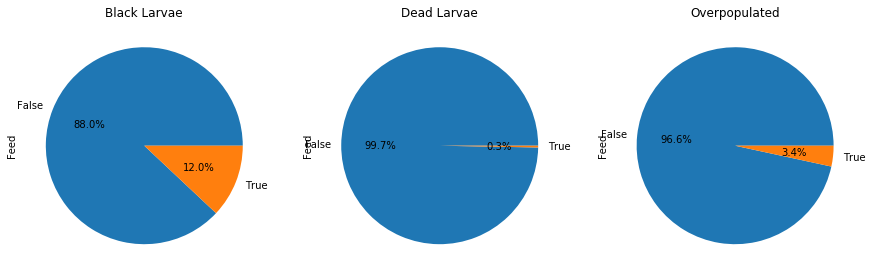

In [412]:
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)
grouped = df['Feed'].groupby(df['Black Larvae']) 
grouped.count().plot.pie(ax=ax1, autopct='%1.1f%%', title='Black Larvae')
grouped = df['Feed'].groupby(df['Dead Larvae']) 
grouped.count().plot.pie(ax=ax2, autopct='%1.1f%%', title='Dead Larvae')
grouped = df['Feed'].groupby(df['Overpopulated']) 
grouped.count().plot.pie(ax=ax3, autopct='%1.1f%%', title='Overpopulated')



<a id='sec05'></a>
# 5. Feature engineering

Work in progress - need more info before completing.

In [413]:

# Days with food leftover
#days_with_food_left = df[df['Food Left'] != 0]['Age'].groupby(df['Tray']).count()
#df = pd.merge(df, days_with_food_left, on='Tray', how='left')
#df.rename(columns={'Age_x': 'Age', 'Age_y': 'days_with_food_left'}, inplace=True)
# Days with black larvae
#days_with_black_larvae = df[df['Black Larvae'] == 1]['Age'].groupby(df['Tray']).count()
#df = pd.merge(df, days_with_black_larvae, on='Tray', how='left')
#df.rename(columns={'Age_x': 'Age', 'Age_y': 'days_with_black_larvae'}, inplace=True)
# Max day with black larvae
#max_day_with_black_larvae = df[df['Black Larvae'] == 1]['Age'].groupby(df['Tray']).max()
#df = pd.merge(df, max_day_with_black_larvae, on='Tray', how='left')
#df.rename(columns={'Age_x': 'Age', 'Age_y': 'max_day_with_black_larvae'}, inplace=True)
# Days with dead larvae
days_with_dead_larvae = df[df['Dead Larvae'] == 1]['Age'].groupby(df['Tray']).count()
df = pd.merge(df, days_with_dead_larvae, on='Tray', how='left')
df.rename(columns={'Age_x': 'Age', 'Age_y': 'days_with_dead_larvae'}, inplace=True)
# Max day with dead larvae
#max_day_with_dead_larvae = df[df['Dead Larvae'] == 1]['Age'].groupby(df['Tray']).max()
#df = pd.merge(df, max_day_with_dead_larvae, on='Tray', how='left')
#df.rename(columns={'Age_x': 'Age', 'Age_y': 'max_day_with_dead_larvae'}, inplace=True)

# NaN handler
df.fillna({
           'days_with_food_left': 0,
           'days_with_black_larvae': 0,
           'max_day_with_black_larvae': 0,
           'days_with_dead_larvae': 0,
           'max_day_with_dead_larvae': 0
          }, inplace=True)
print(df.shape)



(11491, 20)


<a id='sec06'></a>
# 6. Processing

### Replace NULL values

In [414]:
df.fillna({'Previous Feed 1': 0,
           'Previous Feed 2': 0,
           'Previous Feed 3': 0
          }, inplace=True)
df.isnull().sum()

Date                     0
Tray                     0
Age                      0
Temperature              0
Moisture                 0
Food Left                0
Black Larvae             0
Dead Larvae              0
Overpopulated            0
Previous Feed 3          0
Previous Feed 2          0
Previous Feed 1          0
Feed                     0
insp_per_tray            0
start_age                0
age_at_harvest           0
inspection_rate          0
total_feed_per_tray      0
average_daily_feed       0
days_with_dead_larvae    0
dtype: int64

### Convert boolean

In [415]:
def boo(val):
    if val:
        return 1
    else:
        return 0
df['Black Larvae'] = df['Black Larvae'].apply(lambda x: boo(x))
df['Dead Larvae'] = df['Dead Larvae'].apply(lambda x: boo(x))
df['Overpopulated'] = df['Overpopulated'].apply(lambda x: boo(x))

### Food left encoding

In [416]:
def foo(val):
    if val == 'None':
        return 0
    elif val == 'Some':
        return 1
    elif val == 'All':
        return 2
    else:
        return -1
df['Food Left'] = df['Food Left'].apply(lambda x: foo(x))

### Drop non-numeric columns

In [417]:
df.drop('Date', axis=1, inplace=True)
df.drop('Tray', axis=1, inplace=True)  # Numeric, but value represents an ID

### quick review...

In [418]:
# Review values
print('Temperature:', df['Temperature'].unique())
print('Moisture', df['Moisture'].unique())
print('Food Left', df['Food Left'].unique())
print('Black Larvae', df['Black Larvae'].unique())
print('Dead Larvae', df['Dead Larvae'].unique())
print('Overpopulated', df['Overpopulated'].unique())
print('Previous Feed 3', df['Previous Feed 3'].unique())
print('Previous Feed 2', df['Previous Feed 2'].unique())
print('Previous Feed 1', df['Previous Feed 1'].unique())
print('Feed', df['Feed'].unique())
print('Shape', df.shape)
df.head()

Temperature: [ 0  2 -1  1 -2  3 -3 -5]
Moisture [-3 -2 -1  1 -4  3  0  4  2  5  6]
Food Left [0 1 2]
Black Larvae [1 0]
Dead Larvae [0 1]
Overpopulated [0 1]
Previous Feed 3 [0. 3. 1. 2. 4. 5. 6. 7.]
Previous Feed 2 [3. 1. 0. 4. 2. 5. 6. 7.]
Previous Feed 1 [3. 0. 1. 4. 2. 5. 6. 7.]
Feed [3 1 0 2 4 5 6 7]
Shape (11491, 18)


,Age,Temperature,Moisture,Food Left,Black Larvae,Dead Larvae,Overpopulated,Previous Feed 3,Previous Feed 2,Previous Feed 1,Feed,insp_per_tray,start_age,age_at_harvest,inspection_rate,total_feed_per_tray,average_daily_feed,days_with_dead_larvae
0,24,0,-3,0,1,0,0,0.0,3.0,3.0,3,3,24,26,0.115385,7,2.333333,0.0
1,25,2,-2,0,1,0,0,3.0,3.0,3.0,3,3,24,26,0.115385,7,2.333333,0.0
2,26,0,-1,0,1,0,0,3.0,3.0,3.0,1,3,24,26,0.115385,7,2.333333,0.0
3,24,-1,-3,0,1,0,0,0.0,1.0,0.0,1,4,24,27,0.148148,1,0.250000,0.0
4,25,1,-3,0,1,0,0,1.0,0.0,1.0,0,4,24,27,0.148148,1,0.250000,0.0


### Split into training and test set
On the training set, we will discard certain records (but keep these in the test set)


In [419]:
# Split into training/test sets
from sklearn.model_selection import train_test_split
y = df['Feed']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y.shape)

(9192, 18)
(2299, 18)
(9192,)
(2299,)
(11491,)


## Discard data

#### Remove all trays that did not receive any food

In [420]:
print('Shape before deleting:', X_train.shape, y_train.shape)
idx_to_drop = X_train[X_train['total_feed_per_tray'] == 0].index
X_train.drop(idx_to_drop, inplace=True)
y_train.drop(idx_to_drop, inplace=True)
print('Shape after deleting:', X_train.shape, y_train.shape)


Shape before deleting: (9192, 18) (9192,)
Shape after deleting: (9163, 18) (9163,)


/anaconda3/envs/DW/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


#### Trays with incomplete data
We will use discard trays that <80% of days logged.

In [421]:
print('Shape before deleting:', X_train.shape, y_train.shape)
idx_to_drop = X_train[X_train['inspection_rate'] < 0.8].index
X_train.drop(idx_to_drop, inplace=True)
y_train.drop(idx_to_drop, inplace=True)
print('Shape after deleting:', X_train.shape, y_train.shape)

Shape before deleting: (9163, 18) (9163,)
Shape after deleting: (8452, 18) (8452,)


#### Trays with dead larvae
Dead larvae indicate a problem - without knowing any other information on the cause, we will throw out tray data when dead larvae was observed, just in case this is due to feeding patterns

In [422]:
print('Shape before deleting:', X_train.shape, y_train.shape)
idx_to_drop = X_train[X_train['days_with_dead_larvae'] > 0].index
X_train.drop(idx_to_drop, inplace=True)
y_train.drop(idx_to_drop, inplace=True)
print('Shape after deleting:', X_train.shape, y_train.shape)

Shape before deleting: (8452, 18) (8452,)
Shape after deleting: (8027, 18) (8027,)


### Drop new features that will not be used in model

In [423]:
# Drop some additional columns that may not be useful for the model
X_train.drop(['insp_per_tray', 'start_age', 'age_at_harvest', 'inspection_rate', 
         'total_feed_per_tray', 'average_daily_feed', 'days_with_dead_larvae'], axis=1, inplace=True)
X_test.drop(['insp_per_tray', 'start_age', 'age_at_harvest', 'inspection_rate', 
         'total_feed_per_tray', 'average_daily_feed', 'days_with_dead_larvae'], axis=1, inplace=True)

In [424]:
df.to_csv(r'data/FeedRecords_processed.csv')

<a id='sec07'></a>
# 7. Modelling

In [425]:
# Cross validation 
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

## Fit models

### KNN

In [426]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors = 25)
scoring = 'accuracy'
score_knn = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score_knn)

[0.82814446 0.79327522 0.80946451 0.76836862 0.79078456 0.79452055
 0.81569116 0.80922693 0.80673317 0.80049875]


### Logistic Regression

In [427]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
scoring = 'accuracy'
score_logr = cross_val_score(model, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score_logr)

/anaconda3/envs/DW/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/DW/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/DW/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/envs/DW/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/anaconda3/envs/DW/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: Futur

[0.69863014 0.70859278 0.72851806 0.71606476 0.71606476 0.71606476
 0.72229141 0.74314214 0.71820449 0.73566085]


### Random Forest

In [428]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=13)
scoring = 'accuracy'
score_randf = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score_randf)


[0.99875467 0.99875467 0.99875467 1.         0.99501868 0.99875467
 0.99875467 0.99750623 1.         0.99750623]


## Scores

### NB

In [432]:
print('KNN:',round(np.mean(score_knn)*100, 2))
print('LOGISTIC REGRESSION:',round(np.mean(score_logr)*100, 2))
print('DECOSO REGRESSION:',round(np.mean(score_logr)*100, 2))


KNN: 80.17
DECISION TREE: 100.0
LOGISTIC REGRESSION: 72.03
NAIVE BAYES: 100.0
RANDOM FOREST: 99.84
SVM: 99.56


In [429]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
scoring = 'accuracy'
score_gnb = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score_gnb)


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### SVM

In [430]:
from sklearn.svm import SVC
clf = SVC()
scoring = 'accuracy'
score_svm = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score_svm)


/anaconda3/envs/DW/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/envs/DW/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/envs/DW/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/envs/DW/lib/python3.7/site-packages/sklearn/svm/base.py:

[0.99626401 0.99128269 0.99750934 0.99252802 0.99750934 0.99377335
 0.99626401 0.99875312 0.99625935 0.99625935]


In [433]:
# Use best scoring classifier!
#clf = KNeighborsClassifier(n_neighbors = 25)
clf = DecisionTreeClassifier()
#clf = LogisticRegression()
#clf = GaussianNB()
#clf = RandomForestClassifier(n_estimators=13)
#clf = SVC()

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
display(pred)

array([4, 3, 1, ..., 3, 1, 5])

In [434]:
X_test_pred = pd.DataFrame(index=X_test.index, data=pred)

In [436]:
df_pred = pd.merge(X_test, pd.DataFrame(index=X_test.index, data=pred), left_index=True, right_index=True)
df_pred

,Age,Temperature,Moisture,Food Left,Black Larvae,Dead Larvae,Overpopulated,Previous Feed 3,Previous Feed 2,Previous Feed 1,Feed,0
9355,8,1,0,0,0,0,0,3.0,4.0,4.0,4,4
2866,5,0,-1,0,0,0,0,1.0,2.0,3.0,3,3
8393,0,0,0,0,0,0,0,0.0,0.0,0.0,1,1
11042,10,0,-1,0,0,0,0,2.0,2.0,3.0,4,4
3399,11,1,-2,0,0,0,0,3.0,4.0,4.0,5,5
1045,2,0,0,0,0,0,0,0.0,0.0,2.0,3,3
2777,18,-1,-2,0,0,0,0,1.0,1.0,0.0,1,1
1923,9,0,-2,0,0,0,0,5.0,5.0,5.0,6,6
10033,12,0,-2,0,0,0,0,3.0,4.0,4.0,5,5
7780,4,0,0,0,0,0,0,0.0,1.0,3.0,4,4


### Decision tree

In [431]:
'''
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier()
scoring = 'accuracy'
score_dtree = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1, scoring=scoring)
print(score_dtree)
'''

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


<a id='sec08'></a>
# 8. Improving data quality

(pending)

<a id='sec09'></a>
# 9. Black Soldier House Fly - Developmental cycle
For context, some understanding of the larval cycle is in order. In the data, trays have ages associated with them. The overall range of values aligns with the larval cycle for the fly, with the key milestones in the cycle shown below.

#### Larval cycle for the Black Soldier Fly
- 0 = Lay eggs
- 4 = Eggs hatch (Larvae stage starts)
- 19 = Pre-pupal stage starts
- 26 = *Pupal stage starts* - lasts 1 to 2 weeks
- 40 = End
<br>

Reference: https://en.wikipedia.org/wiki/Hermetia_illucens#Larval_colonies

<font color=red>*Fotis has indicated that we should review the numbers as-is instead of relying on any insight into the developmental cycle and how it is involved in the production process.*</font>